In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
# from signal import signal, SIGPIPE, SIG_DFL
# signal(SIGPIPE,SIG_DFL)

In [4]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import wandb

In [6]:
wandb.login(key='6264e29f109d3cf02a9911cd18b6725b79c489cd')

wandb: Currently logged in as: cs22m043. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
np.random.seed(0)

In [8]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [10]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [11]:
x_train = x_train.reshape(len(x_train),784)
x_test = x_test.reshape(len(x_test),784)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(54000, 784)
(54000,)
(6000, 784)
(6000,)


In [14]:
enc = OneHotEncoder()
y_OHE_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OHE_val = enc.fit_transform(np.expand_dims(y_val,1)).toarray()
y_OHE_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
print(y_OHE_train.shape, y_OHE_val.shape, y_OHE_test.shape)

(54000, 10) (6000, 10) (10000, 10)


In [15]:
class FFNNClass:   
    def __init__(self, hidden_sizes=[3], algo='SGD', initialization='xavier', activation='sigmoid', loss='cross_entropy'):
        #self.nx = n_inputs
        #self.ny = n_outputs
        self.nx = 784
        self.ny = 10
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny] 
        self.algo = algo
        self.params={}
        #self.gradients={}
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        self.update_params={}
        self.prev_update_params={}
        self.initialization = initialization
        self.activation = activation
        self.loss = loss
        for i in range(self.nh+1):
            self.update_params["v_w"+str(i+1)]=0
            self.update_params["v_b"+str(i+1)]=0
            self.update_params["m_b"+str(i+1)]=0
            self.update_params["m_w"+str(i+1)]=0
            self.prev_update_params["v_w"+str(i+1)]=0
            self.prev_update_params["v_b"+str(i+1)]=0
            
        if initialization=='xavier':
            for i in range(self.nh+1):
                self.params["W"+str(i+1)]= np.random.randn(self.sizes[i], self.sizes[i+1]) * np.sqrt(1/(self.sizes[i]+self.sizes[i+1]))
                self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
        elif initialization=='random':
            for i in range(self.nh+1):
                self.params["W"+str(i+1)]= np.random.randn(self.sizes[i], self.sizes[i+1]) * 0.01
                self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
            
    def sigmoid(self, x):
        #return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        x = np.clip(x, -500, 500)
        return 1.0/(1.0 + np.exp(-x))
    def grad_sigmoid(self, x):
        return x*(1-x)
    
    def relu(self, x):
        return np.maximum(0,x)
    def grad_relu(self, x):
        return 1*(x>0)
    
    def tanh(self, x):
        return np.tanh(x)
    def grad_tanh(self, x):
        return (1 - (np.tanh(x)**2))

    def softmax(self, x):
        eps = 1e-9
        exps = np.exp(x)
        return exps / (np.sum(exps,axis=1).reshape(-1,1) + eps)

    def forward_pass(self, x, params=None):
        if params is None:
            params=self.params
        self.A = {}
        self.H = {}
        #self.H[0] = x.reshape(1, -1)
        self.H[0] = x  #dimension is 16 * 784
        for i in range(self.nh):
            self.A[i+1] = np.matmul(self.H[i], params["W"+str(i+1)]) + params["B"+str(i+1)]
            if self.activation == 'sigmoid':
                self.H[i+1] = self.sigmoid(self.A[i+1])
            elif self.activation == 'tanh':
                self.H[i+1] = self.tanh(self.A[i+1])
            elif self.activation == 'relu':
                self.H[i+1] = self.relu(self.A[i+1])
        self.A[self.nh+1] = np.matmul(self.H[self.nh], params["W"+str(self.nh+1)]) + params["B"+str(self.nh+1)]
        self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
        return self.H[self.nh+1]

    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()
    
    def compute_loss(self, Y, Y_hat, batch_size, lamb):

        if self.loss == 'cross_entropy':
            L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
        elif self.loss == 'mse':
            L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

        #Add L2 regularisation
        acc = 0
        for i in range(1, self.nh + 1):
            acc += np.sum(self.params["W"+str(i)]**2)

        L = L + (lamb/(2*batch_size))*acc

        return L

    def grad(self, x, y, params=None):
        if params is None:
            params=self.params
        self.forward_pass(x,params)
        m = x.shape[0]
        L = self.nh + 1
        if self.loss == 'cross_entropy':
            self.dA[L] = (self.H[L] - y)
        elif self.loss == 'mse':
            self.dA[L] = (self.H[L] - y) * self.H[L] * (1-self.H[L])
        for k in range(L, 0, -1):
            self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
            self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
            self.dH[k-1] = np.matmul(self.dA[k], params["W"+str(k)].T)
            if self.activation == 'sigmoid':
                self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
            elif self.activation == 'tanh':
                self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_tanh(self.H[k-1]))
            elif self.activation == 'relu':
                self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_relu(self.H[k-1]))
          
    def plot_loss_curve(self,train_costs, val_costs):
        '''
        Plots the train and validation cost curves
        '''
        #print("dheeraj")
        #plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
        plt.plot(train_costs.values(), 'r', label="Training loss")
        #print("abc")
        #plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
        plt.plot(val_costs.values(), 'lime', label="validation loss")
        #print("varma")
        plt.title("Training and Validation Loss vs Number of Epochs", size=14)
        plt.xlabel("Number of epochs", size=14)
        plt.ylabel("Loss", size=14)
        plt.grid()
        plt.legend()
        plt.show()

    def fit(self, X, Y, X_VAL, Y_VAL,  epochs = 5, eta=0.01, display_loss=False, gamma=0.9, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, mini_batch_size=1,wt_decay=0.0):

        #if display_loss:
        train_loss = {}
        val_loss = {}
        train_acc = {}
        val_acc = {}
        M = X.shape[0]
        Mval = X_VAL.shape[0]
                
        if self.algo == "GD":
            for epoch in range(epochs):
                m = X.shape[0]
                self.grad(X,Y)
                for i in range(self.nh+1):
                    self.params["W"+str(i+1)] -= (eta * (self.dW[i+1]/m) + eta*wt_decay*(self.dW[i+1]/m))
                    self.params["B"+str(i+1)] -= eta * (self.dB[i+1]/m)
                #if display_loss:
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)
        elif self.algo == "SGD":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(self.nh+1):
                        self.params["W"+str(i+1)] -= (eta * (self.dW[i+1]/mini_batch_size) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= eta * (self.dB[i+1]/mini_batch_size)
                #if display_loss:
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)

                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)
                        
        elif self.algo == "Momentum":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                #self.grad(X, Y)
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/mini_batch_size)
                        self.params["W"+str(i+1)] -= (self.update_params["v_w"+str(i+1)] + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= self.update_params["v_b"+str(i+1)]
                #if display_loss:
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)

                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)
                        
        
        elif self.algo == "RMS_Prop":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                #self.grad(X, Y)
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)] = beta*self.update_params["v_w"+str(i+1)] +(1-beta)*((self.dW[i+1]/mini_batch_size)**2)
                        self.update_params["v_b"+str(i+1)] = beta*self.update_params["v_b"+str(i+1)] +(1-beta)*((self.dB[i+1]/mini_batch_size)**2)
                        self.params["W"+str(i+1)] -= ((eta/(np.sqrt(self.update_params["v_w"+str(i+1)]+eps)))*(self.dW[i+1]/mini_batch_size) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i+1)]+eps)))*(self.dB[i+1]/mini_batch_size)
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)
                        
        elif self.algo == "NAG":
            for epoch in range(epochs):
                m = X.shape[0]
                temp_params = {}
                
                for k in range(0,m,mini_batch_size):
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)]=gamma*self.prev_update_params["v_w"+str(i+1)]
                        self.update_params["v_b"+str(i+1)]=gamma*self.prev_update_params["v_b"+str(i+1)]
                        temp_params["W"+str(i+1)]=self.params["W"+str(i+1)]-self.update_params["v_w"+str(i+1)]
                        temp_params["B"+str(i+1)]=self.params["B"+str(i+1)]-self.update_params["v_b"+str(i+1)]
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size],temp_params)
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/mini_batch_size)
                        self.params["W"+str(i+1)] -= (eta * (self.update_params["v_w"+str(i+1)]) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= eta * (self.update_params["v_b"+str(i+1)])
                    self.prev_update_params=self.update_params 
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)
                    
        elif self.algo == "Adam":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    num_updates=0
                    for i in range(self.nh+1):
                        num_updates+=1
                        self.update_params["m_w"+str(i+1)]=beta1*self.update_params["m_w"+str(i+1)]+(1-beta1)*(self.dW[i+1]/mini_batch_size)
                        self.update_params["v_w"+str(i+1)]=beta2*self.update_params["v_w"+str(i+1)]+(1-beta2)*((self.dW[i+1]/mini_batch_size)**2)
                        m_w_hat=self.update_params["m_w"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_w_hat=self.update_params["v_w"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["W"+str(i+1)] -=((eta/np.sqrt(v_w_hat+eps))*m_w_hat + eta*wt_decay*(self.dW[i+1]/mini_batch_size))

                        self.update_params["m_b"+str(i+1)]=beta1*self.update_params["m_b"+str(i+1)]+(1-beta1)*(self.dB[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)]=beta2*self.update_params["v_b"+str(i+1)]+(1-beta2)*((self.dB[i+1]/mini_batch_size)**2)
                        m_b_hat=self.update_params["m_b"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_b_hat=self.update_params["v_b"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["B"+str(i+1)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
                
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                # if self.loss == 'cross_entropy':
                #     train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                #     val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                #     print(train_loss[epoch])
                #     print(val_loss[epoch])
                # elif self.loss == 'mse':
                #     train_loss[epoch] = mean_squared_error(Y,Y_pred)
                #     train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
                # Mean loss for the full training set
                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)
                        
        elif self.algo == "NAdam":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    num_updates=0
                    for i in range(self.nh+1):
                        num_updates+=1
                        self.update_params["m_w"+str(i+1)]=beta1*self.update_params["m_w"+str(i+1)]+(1-beta1)*(self.dW[i+1]/mini_batch_size)
                        self.update_params["v_w"+str(i+1)]=beta2*self.update_params["v_w"+str(i+1)]+(1-beta2)*((self.dW[i+1]/mini_batch_size)**2)
                        m_w_hat=self.update_params["m_w"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_w_hat=self.update_params["v_w"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["W"+str(i+1)] -=((eta/np.sqrt(v_w_hat+eps))*((beta1*m_w_hat + (1-beta1)*v_w_hat)/(1-beta1)) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))

                        self.update_params["m_b"+str(i+1)]=beta1*self.update_params["m_b"+str(i+1)]+(1-beta1)*(self.dB[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)]=beta2*self.update_params["v_b"+str(i+1)]+(1-beta2)*((self.dB[i+1]/mini_batch_size)**2)
                        m_b_hat=self.update_params["m_b"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_b_hat=self.update_params["v_b"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["B"+str(i+1)] -=(eta/np.sqrt(v_b_hat+eps))*((beta1*m_b_hat + (1-beta1)*v_b_hat)/(1-beta1))
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                full_output = self.forward_pass(X)
                cost = self.compute_loss(Y, full_output, M, wt_decay)
                train_loss[epoch] = cost
                
                # Mean loss for the validation set
                out = self.forward_pass(X_VAL)
                val_cost = self.compute_loss(Y_VAL, out, Mval, wt_decay)
                val_loss[epoch] = val_cost

                print(cost)
                print(val_cost)

        self.plot_loss_curve(train_loss, val_loss)            
        
        
        return train_acc,val_acc,train_loss,val_loss

0.4869550831396399
0.5254660273434759
0.3980459077621826
0.437853006239021
0.34752658756098453
0.39238048228490946
0.3299853674414107
0.37852789337797155
0.3177438134284385
0.3746033968113757
0.29984374973264877
0.36027264933130343
0.28149246807856343
0.34970233296052033
0.26969806033109683
0.3427210516900087
0.26330363765898235
0.3429162373304973
0.25940951977926874
0.3441473205255204


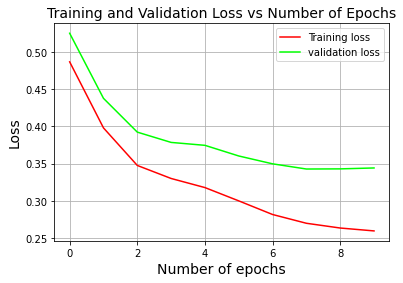

In [16]:
ffnn = FFNNClass(hidden_sizes=[128,128,128],algo = 'Momentum',initialization = 'xavier', activation = 'relu', loss = 'cross_entropy')
a,b,c,d = ffnn.fit(x_train,y_OHE_train,x_val,y_OHE_val, epochs=10, eta=0.01,display_loss = True,mini_batch_size=64,wt_decay=0.05)

In [17]:
y_pred_train = ffnn.predict(x_train)
y_pred_train = np.argmax(y_pred_train,1)

train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training accuracy", round(train_accuracy, 3))
#print(y_pred_train.shape)
#print(y_train.shape)

Training accuracy 0.903


In [18]:
y_pred_val = ffnn.predict(x_val)
y_pred_val = np.argmax(y_pred_val,1)
val_accuracy = accuracy_score(y_val, y_pred_val)
print("validation accuracy", round(val_accuracy, 3))

validation accuracy 0.881


In [19]:
y_pred_test = ffnn.predict(x_test)
y_pred_test = np.argmax(y_pred_test,1)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy", round(test_accuracy, 3))

Testing accuracy 0.876


In [20]:
from sklearn.metrics import confusion_matrix 

Test accuracy  0.8756


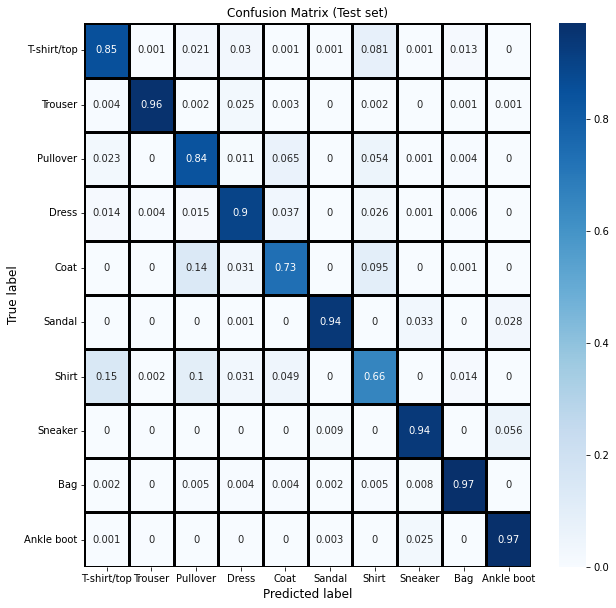

In [21]:
wandb.init(name = 'confusion matrix', project="Assignment1", entity="cs22m043")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_test = ffnn.predict(x_test)
y_pred_test = np.argmax(y_pred_test,1)
test_accuracy = accuracy_score(y_test, y_pred_test)

bern_cnf_matrix_train = confusion_matrix(y_test, y_pred_test, normalize='true')

df_conf_matrix = pd.DataFrame(bern_cnf_matrix_train,index = [i for i in class_names], columns=[i for i in class_names])
plt.figure(figsize=(10,10))
#ax = sns.heatmap(bern_cnf_matrix_train,annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
ax = sns.heatmap(df_conf_matrix, annot=True, cmap='Blues', linewidth=3, linecolor='black')
size1 = 12
ax.set_yticklabels(class_names,rotation=0)
ax.set_title("Confusion Matrix (Test set)", size=size1)
ax.set_xlabel("Predicted label", size=size1)
ax.set_ylabel("True label", size=size1)
plt.savefig("Test_confusionmatrix")
# Load the confusion matrix images
img1 = plt.imread("Test_confusionmatrix.png")

print("Test accuracy ",test_accuracy)
# Log images of the confusion matrices
wandb.log({"Confusion Matrix - Test set": wandb.Image(img1)})